Reads the csv from the website: rename the csv to results_day.csv as opposed to the weird string of numbers it autonames it

In [105]:
import re
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from statsmodels.tsa.seasonal import STL
plt.rcParams["figure.figsize"] = (20, 10)

In [106]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

sns.set(style='white')
#iris = _sns.load_dataset('iris')

def my_scatter(x,y, **kwargs):
    key_name = kwargs.pop('key_name', None)
    if (x.name == key_name) or (y.name == key_name):
        kwargs['color'] = 'red'
    else: kwargs['color'] = '#1f77b4'
    plt.scatter(x,y, **kwargs)

def my_hist(x, **kwargs):
    key_name = kwargs.pop('key_name', None)
    if (x.name == key_name):
        kwargs['color'] = 'red'
    else: kwargs['color'] = '#1f77b4'
    plt.hist(x, **kwargs)

def my_kde(x,y, **kwargs):
    key_name = kwargs.pop('key_name', None)
    if (x.name == key_name) or (y.name == key_name):
        kwargs['cmap'] = 'Reds_d'
    else: kwargs['cmap'] = 'Blues_d'
    sns.kdeplot(x = x,y = y, **kwargs)

def corrfunc(x, y, **kwargs):
  r, p = stats.pearsonr(x, y)
  p_stars = ''
  if p <= 0.05:
    p_stars = '*'
  if p <= 0.01:
    p_stars = '**'
  if p <= 0.001:
    p_stars = '***'
  ax = plt.gca()
  ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.05, 0.9), xycoords=ax.transAxes)

def annotate_colname(x, **kwargs):
  ax = plt.gca()
  ax.annotate(x.name, xy=(0.05, 0.9), xycoords=ax.transAxes,
              fontweight='bold')

def annotate_colname(x, **kwargs):
  ax = plt.gca()
  ax.annotate(x.name, xy=(0.05, 0.9), xycoords=ax.transAxes,
              fontweight='bold')

def cor_matrix(df, as_returns = False, fname = None, key_name = None):
  if as_returns == True:
      df = df.select_dtypes(include=numerics)
      df = df.pct_change(1)
      df = df.dropna()
  g = sns.PairGrid(df, palette=['red'])
  # Use normal regplot as `lowess=True` doesn't provide CIs.
  g.map_upper(my_scatter, key_name = key_name)
  g.map_diag(my_hist, key_name = key_name)
  g.map_diag(annotate_colname)
  g.map_lower(my_kde, key_name = key_name)
  g.map_lower(corrfunc)
  # Remove axis labels, as they're in the diagonals.
  for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')
  if fname is not None:
      plt.savefig(fname, dpi=600, bbox_inches='tight')
  plt.show()
  return g

In [107]:
def parse_dat(file):
    """
    parses the results csv, named as results_[day].csv
    """
    day_lookup = r"(?<=_)(.*)(?=\.)"
    day = re.findall(day_lookup,file)[0]
    #print(fname)
    df = pd.read_csv(file, index_col=False, sep=";")
    return day,  df

In [108]:
output_dfs = {}
mypath = os.getcwd()
for afile in glob.glob(mypath +'/*.csv', recursive=True):
    name, output = parse_dat(afile)
    #create unique list of names
    products = output['product'].unique()
    #create a data frame dictionary to store your data frames
    dfs = {elem : pd.DataFrame() for elem in products}
    for key in dfs.keys():
        dfs[key] = output[:][output["product"] == key]
    output_dfs[name]=dfs

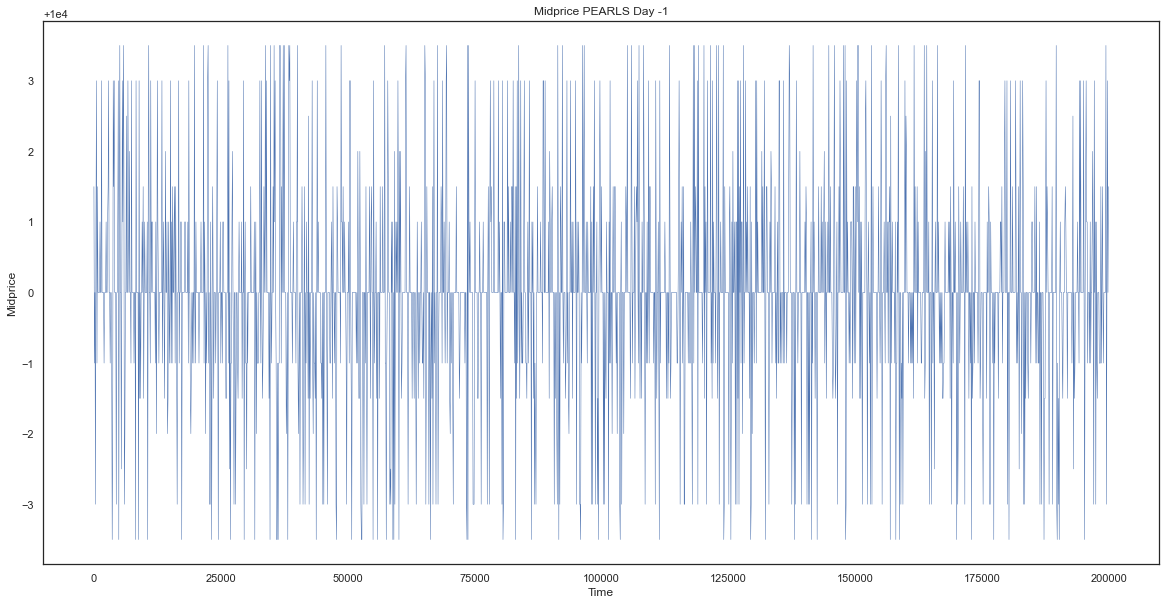

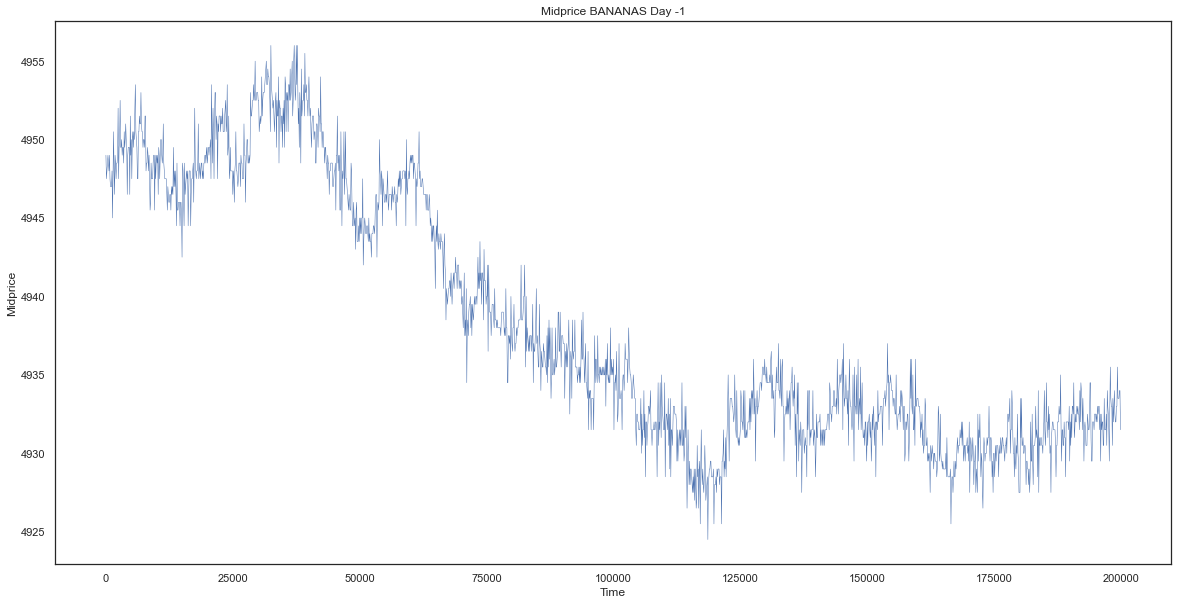

In [109]:
for day, assets in output_dfs.items():
    for asset, data in assets.items():
        plt.plot(data['timestamp'], data['mid_price'], label = asset, linewidth = 0.5)
        plt.xlabel('Time')
        plt.ylabel('Midprice')
        plt.title('Midprice ' + asset + " Day " + day)
        plt.show()

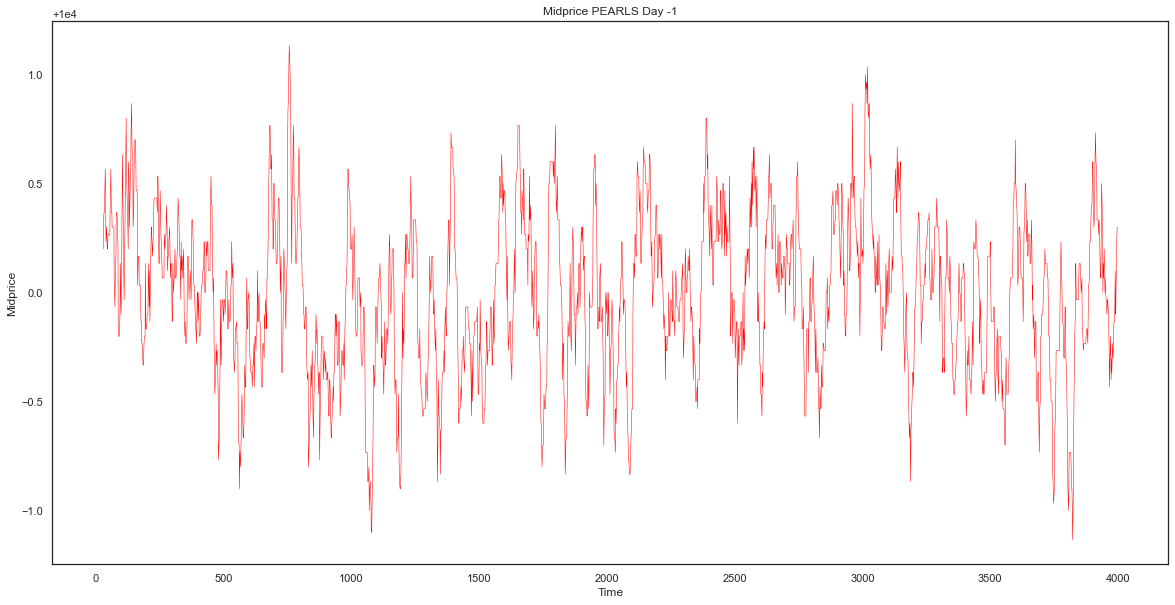

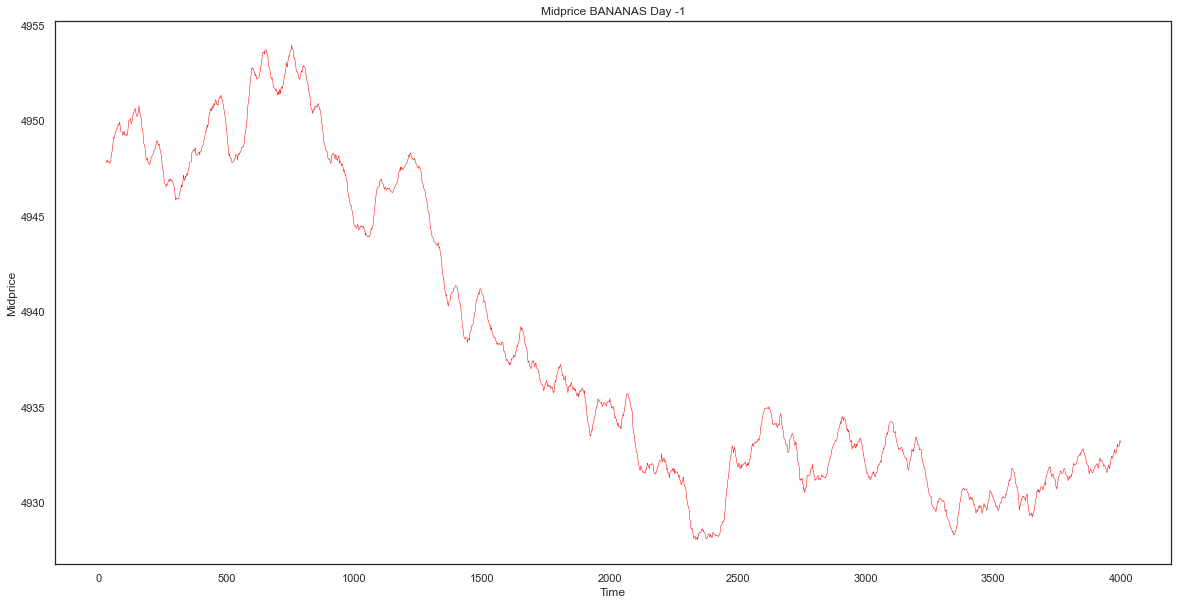

In [110]:
for day, assets in output_dfs.items():
    for asset, data in assets.items():
        periods = 15
        mid_average = data['mid_price'].rolling(window=periods).mean()
        # plt.plot(data['mid_price'] , label = "mid price", linewidth = 0.5, color = "black")
        plt.plot(mid_average , label = str(periods)+"rolling average", linewidth = 0.5, color = "red")
        plt.xlabel('Time')
        plt.ylabel('Midprice')
        # plt.legend()
        plt.title('Midprice ' + asset + " Day " + day)
        plt.show()

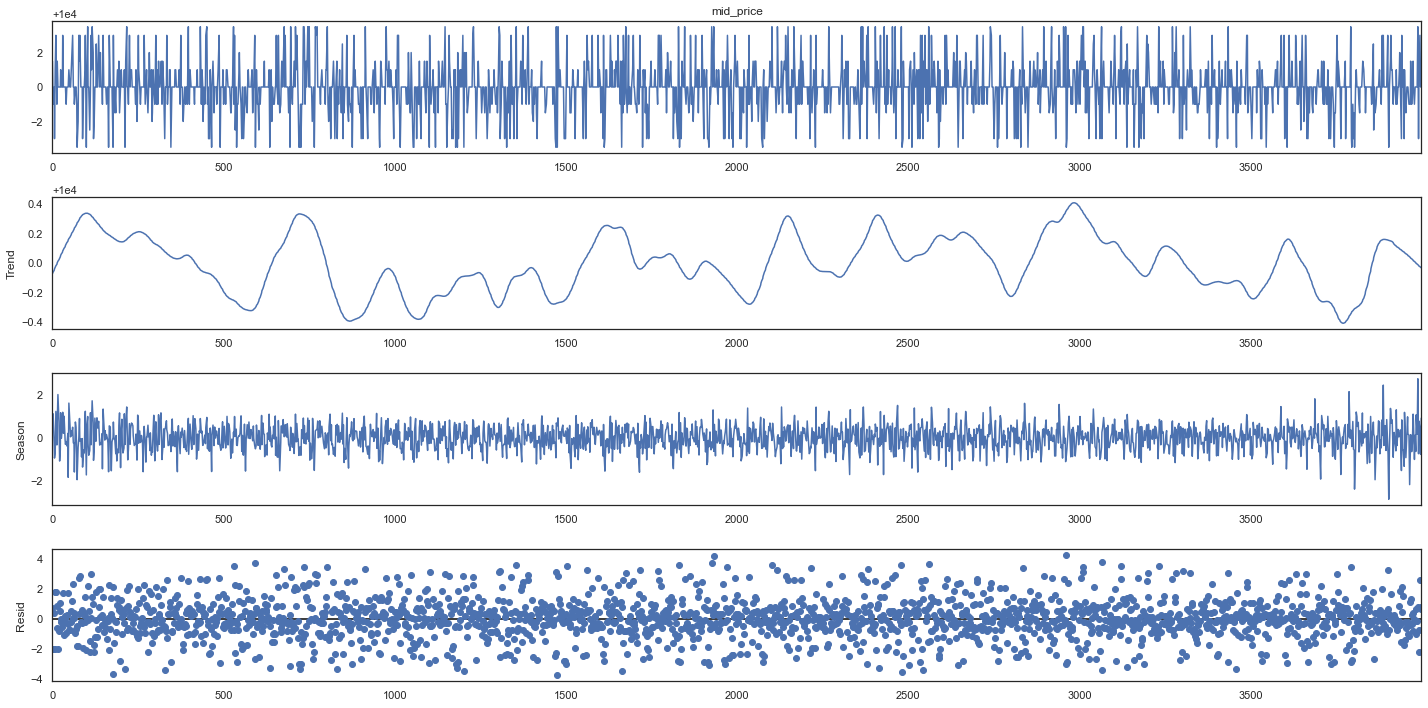

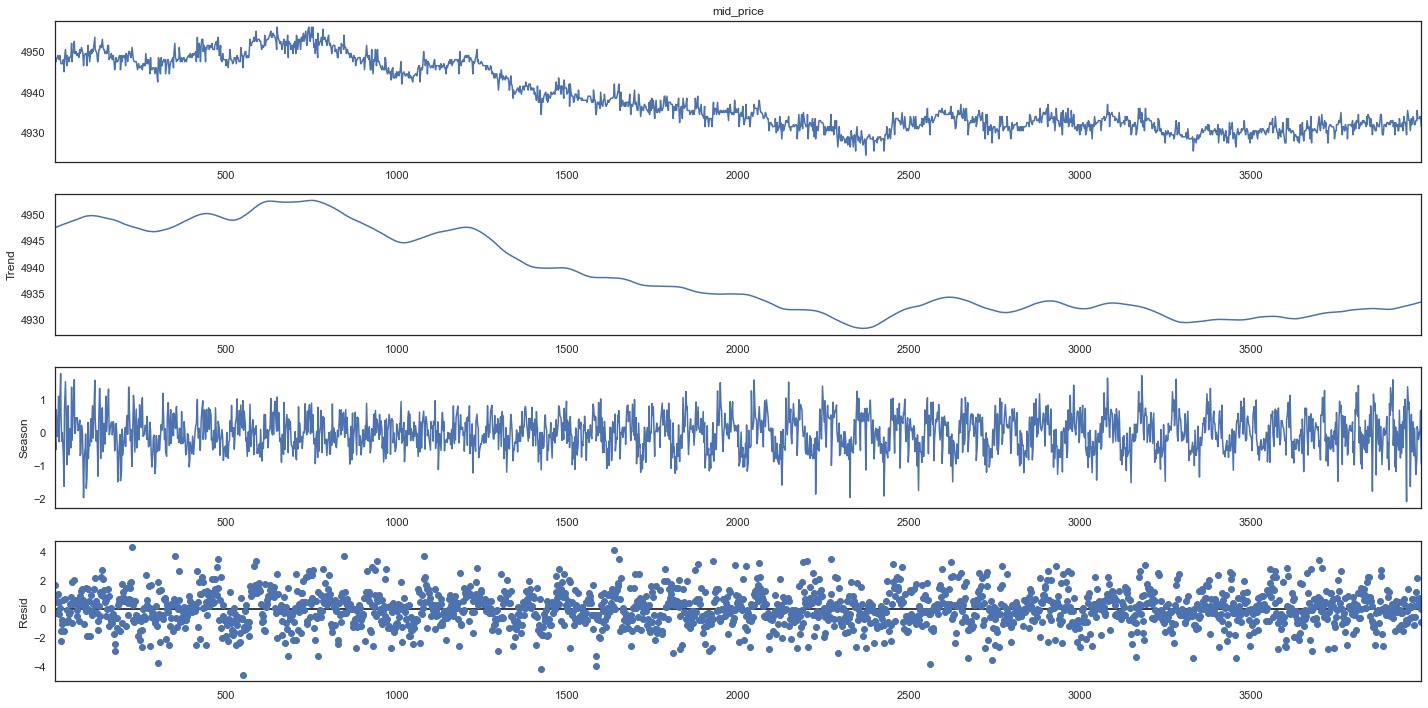

In [119]:
for day, assets in output_dfs.items():
    for asset, data in assets.items():
        stl = STL(data['mid_price'], seasonal=13, period = 50)
        res = stl.fit()
        fig = res.plot()

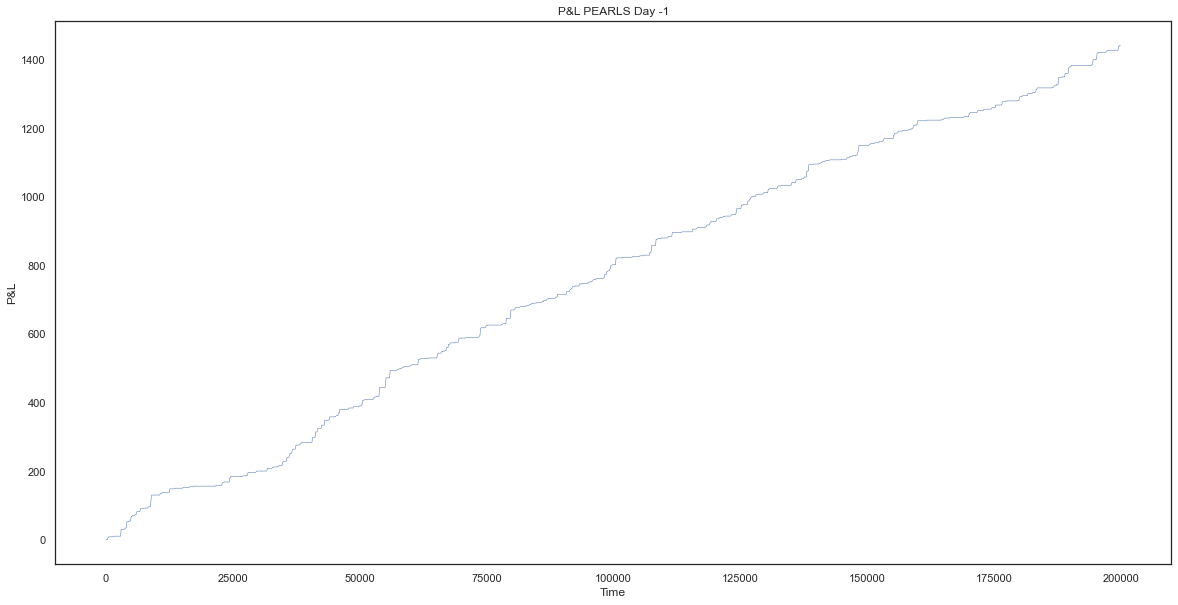

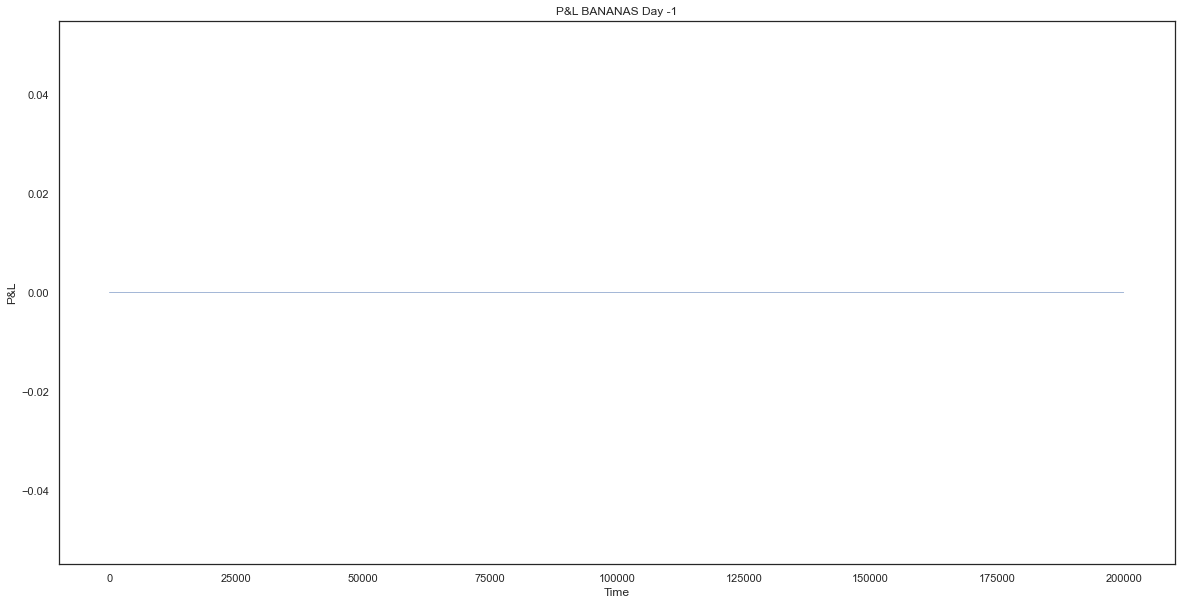

In [ ]:
for day, assets in output_dfs.items():
    for asset, data in assets.items():
        plt.plot(data['timestamp'], data['profit_and_loss'], label = asset, linewidth = 0.5)
        plt.xlabel('Time')
        plt.ylabel('P&L')
        plt.title('P&L ' + asset + " Day " + day)
        plt.show()

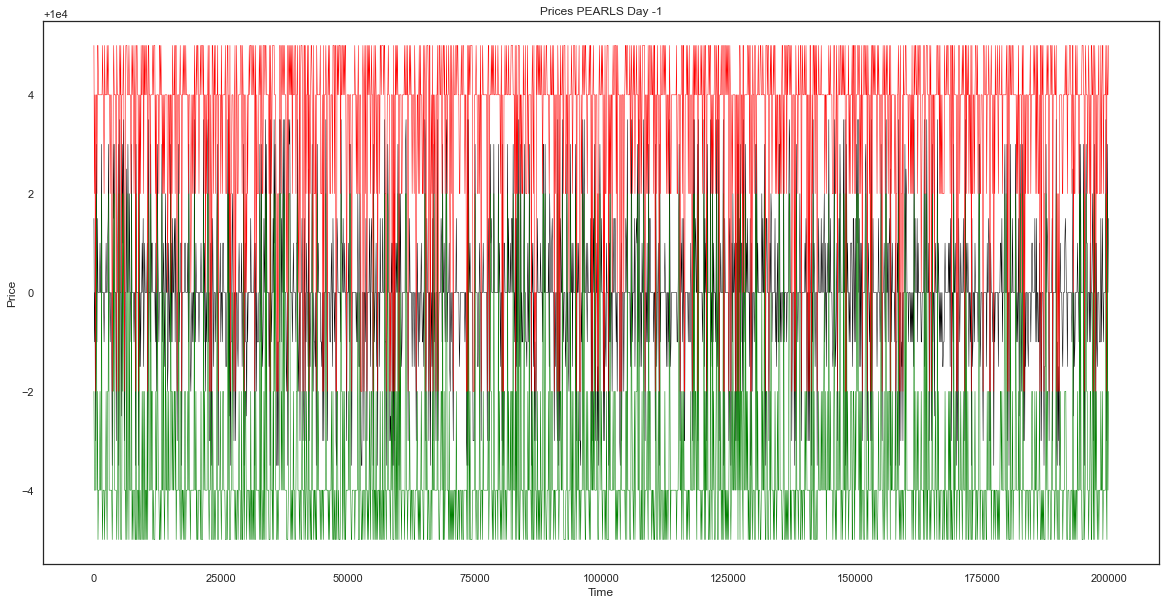

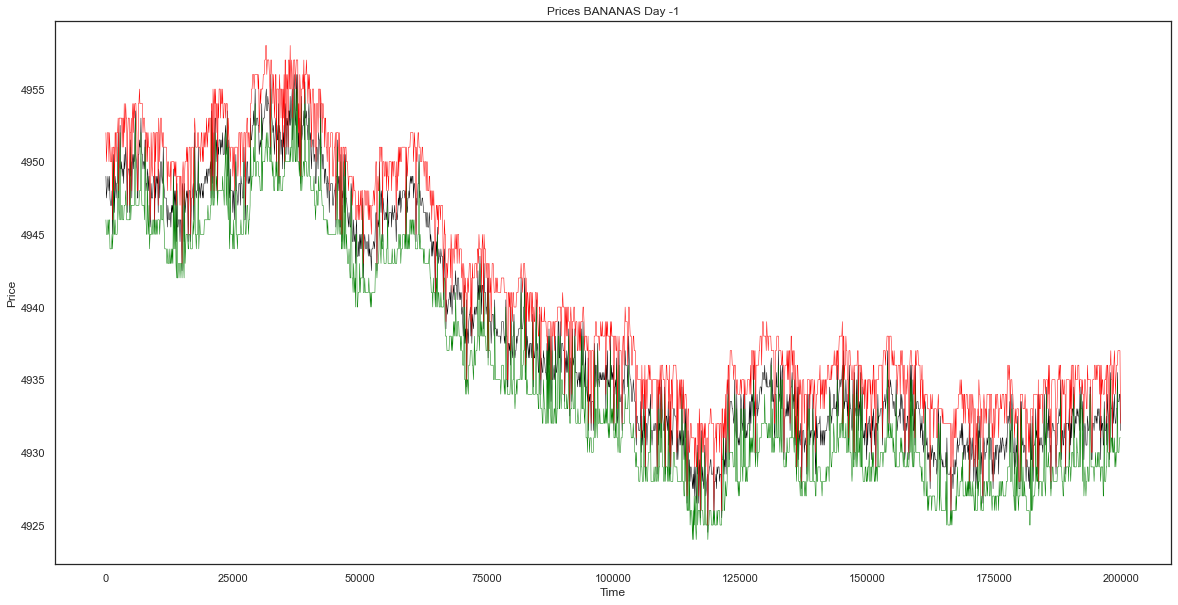

In [ ]:
for day, assets in output_dfs.items():
    for asset, data in assets.items():
        plt.plot(data['timestamp'], data['mid_price'], label = asset, linewidth = 0.5, color = 'black')
        plt.plot(data['timestamp'], data['bid_price_1'], label = asset, linewidth = 0.5, color = 'green')
        plt.plot(data['timestamp'], data['ask_price_1'], label = asset, linewidth = 0.5, color = 'red')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.title('Prices ' + asset + " Day " + day)
        plt.show()

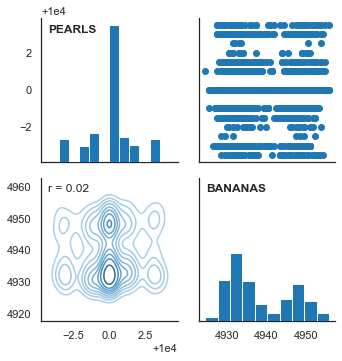

In [ ]:
for day, assets in output_dfs.items():
    # set the time to the index
    dfs = [asset.set_index('timestamp') for _, asset in assets.items()]
    # keep only the midprice
    dfs = [df[["product", "mid_price"]] for df in dfs]
    dfs = [df.add_suffix("_" + df["product"][0]) for df in dfs]
    df = pd.concat(dfs, axis=1)
    # strip out the product columns
    df = df[df.columns.drop(list(df.filter(regex='product')))]
    # strip out the mid_price_prefix
    df.columns = df.columns.str.lstrip('mid_price_')
    cor_matrix(df)